# Air Quality Forecasting: CO(GT) and NO₂(GT)

> This notebook implements an end-to-end workflow for:
- Data preprocessing (datetime parsing, resampling, missing values, outliers)
- EDA (trend, seasonality, correlation)
- Feature engineering (lags, rolling stats, time features)
- Forecasting models (Statistical SARIMAX, Machine Learning, Deep Learning LSTM)
- Evaluation (MAE, RMSE, MAPE) and visualizations
- Insights & recommendations scaffolding

> **Dataset expected:** A CSV containing `Date`, `Time`, `CO(GT)`, `NO2(GT)` and (optionally) `T`, `RH`, `AH`.


In [144]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
from tensorflow import keras
from statsmodels.tsa.statespace.sarimax import SARIMAX

## Load data + preprocessing

In [145]:
#Loading the dataset from Github
df = pd.read_csv("https://raw.githubusercontent.com/toahirhussain/Time-Series-Forecasting-of-Carbon-Monoxide-and-Nitrogen-Dioxide-Levels/refs/heads/main/airquality.csv")

In [146]:
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
1,2004-03-10,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2,2004-03-10,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
3,2004-03-10,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
4,2004-03-10,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888


In [ ]:
# Define target variables (pollutant concentrations to forecast) and exogenous environmental predictors
TARGETS = ["CO(GT)", "NO2(GT)"]
EXOG = ["T", "RH", "AH"]

In [148]:
#Converting numeric columns safely
for c in df.columns:
    if c not in ["Date", "Time"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")

In [149]:
df.dtypes

Date              object
Time              object
CO(GT)           float64
PT08.S1(CO)        int64
NMHC(GT)           int64
C6H6(GT)         float64
PT08.S2(NMHC)      int64
NOx(GT)            int64
PT08.S3(NOx)       int64
NO2(GT)            int64
PT08.S4(NO2)       int64
PT08.S5(O3)        int64
T                float64
RH               float64
AH               float64
dtype: object

In [150]:
#Combining date+time into datetime index
df["datetime"] = pd.to_datetime(df["Date"].astype(str) + " " + df["Time"].astype(str),
                                errors="coerce", dayfirst=True)
df = df.dropna(subset=["datetime"]).set_index("datetime").sort_index()

In [151]:
#Converting -200 sentinel to NaN (common in Air Quality datasets)
df = df.replace(-200, np.nan)

In [152]:
#keeping only numeric columns
df_numeric = df.select_dtypes(include=["number"])

In [153]:
# Resample to hourly mean (robust even if there are duplicates)
df_daily = df_numeric.resample("d").mean()

In [154]:
#Basic missing-value imputation for targets: time interpolation + rolling median fallback
df_daily[TARGETS] = (
    df_daily[TARGETS]
    .interpolate(method="time")
    .fillna(df_daily[TARGETS].rolling(24, min_periods=1).median())
)

def cap_outliers(s, low=0.01, high=0.99):
    lo, hi = s.quantile(low), s.quantile(high)
    return s.clip(lo, hi)

for t in TARGETS:
    df_daily[t] = cap_outliers(df_daily[t])

df_daily.head()


,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
datetime,,,,,,,,,,,,,
2004-01-04,2.550000,1244.380952,310.125,11.971429,1010.428571,161.304348,880.666667,96.739130,1644.380952,1155.857143,15.519048,51.133333,0.854881
2004-01-05,2.056522,1097.500000,275.000,8.662500,913.708333,104.739130,918.083333,84.956522,1640.416667,904.625000,20.150000,52.183333,1.167312
2004-01-06,2.100000,1135.583333,NaN,12.375000,1021.875000,152.043478,896.791667,75.869565,1881.500000,1066.958333,20.325000,66.154167,1.533350
2004-01-07,2.162500,1130.583333,NaN,12.225000,1038.541667,139.695652,740.916667,113.434783,1854.250000,1059.625000,30.450000,39.691667,1.624108
2004-01-08,0.983333,974.166667,NaN,5.808333,792.583333,51.739130,880.083333,62.904348,1559.000000,670.583333,30.654167,42.120833,1.673521


## Exploratory Data Analysis (EDA)

- Trend plots
- Hour-of-day seasonality
- Correlations (targets vs. weather predictors)


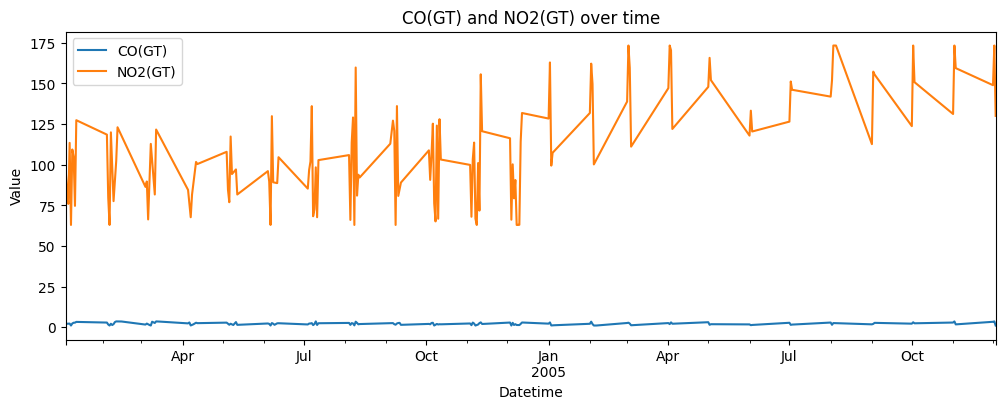

In [155]:
# Trend
df_daily[TARGETS].plot(figsize=(12,4))
plt.title("CO(GT) and NO2(GT) over time")
plt.xlabel("Datetime")
plt.ylabel("Value")
plt.show()

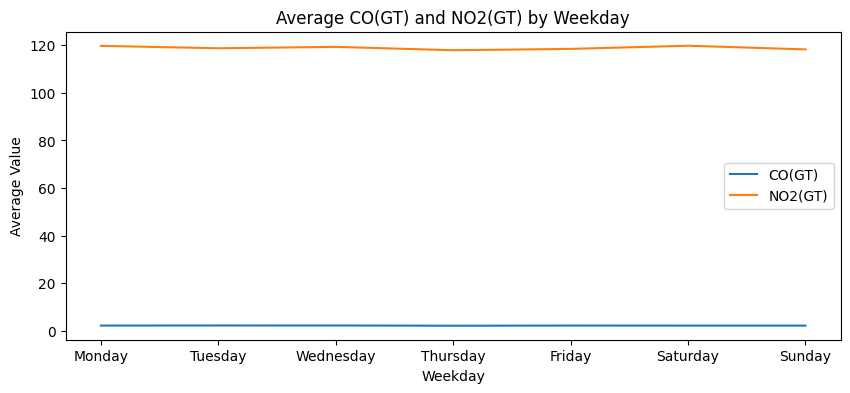

In [156]:
# Seasonality by weekday (named)
tmp = df_daily.copy()
tmp["weekday"] = tmp.index.day_name()

order = ["Monday", "Tuesday", "Wednesday", "Thursday",
         "Friday", "Saturday", "Sunday"]

tmp.groupby("weekday")[["CO(GT)", "NO2(GT)"]].mean().loc[order].plot(figsize=(10,4))

plt.title("Average CO(GT) and NO2(GT) by Weekday")
plt.xlabel("Weekday")
plt.ylabel("Average Value")
plt.show()

In [157]:
#Correlation matrix
cols = [c for c in EXOG if c in df_daily.columns] + TARGETS
corr = df_daily[cols].corr()
corr

,T,RH,AH,CO(GT),NO2(GT)
T,1.000000,-0.440981,0.805253,-0.183504,-0.532630
RH,-0.440981,1.000000,0.116350,0.380130,-0.029712
AH,0.805253,0.116350,1.000000,-0.034581,-0.630820
CO(GT),-0.183504,0.380130,-0.034581,1.000000,0.318564
NO2(GT),-0.532630,-0.029712,-0.630820,0.318564,1.000000


## Feature engineering (lags, rolling stats, time features)

> Creating supervised learning features for each target independently.


In [158]:
def make_features(data: pd.DataFrame, target: str,
                  lags=(1,2,3,6,12,24),
                  rolls=(3,6,12,24),
                  exog_cols=("T","RH","AH")):
    df = data.copy()

    # Time features
    df["hour"] = df.index.hour
    df["dow"] = df.index.dayofweek
    df["month"] = df.index.month

    # Lag features
    for L in lags:
        df[f"{target}_lag_{L}"] = df[target].shift(L)

    # Rolling features (use shift(1) to avoid leakage)
    for w in rolls:
        df[f"{target}_roll_mean_{w}"] = df[target].shift(1).rolling(w).mean()
        df[f"{target}_roll_std_{w}"] = df[target].shift(1).rolling(w).std()

    # Exogenous predictors (optional)
    for ex in exog_cols:
        if ex in df.columns:
            df[ex] = df[ex].interpolate("time")

    df = df.dropna()
    y = df[target]
    X = df.drop(columns=[target])
    return X, y

X_co, y_co = make_features(df_daily, "CO(GT)")
X_no2, y_no2 = make_features(df_daily, "NO2(GT)")

X_co.shape, X_no2.shape


((13, 29), (13, 29))

## Train/test split + evaluation metrics


In [159]:
def mape(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (np.maximum(np.abs(y_true), eps)))) * 100

def eval_forecast(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred) 
    rmse = np.sqrt(mse)
    mp = mape(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "MAPE": mp}

def time_split(X, y, test_size=0.2):
    n = len(X)
    cut = int(n * (1 - test_size))
    return X.iloc[:cut], X.iloc[cut:], y.iloc[:cut], y.iloc[cut:]


def plot_actual_pred(y_true, y_pred, title):
    plt.figure(figsize=(12,4))
    plt.plot(y_true.index, y_true.values, label="Actual")
    plt.plot(y_true.index, y_pred, label="Predicted")
    plt.title(title)
    plt.xlabel("Datetime")
    plt.ylabel("Value")
    plt.legend()
    plt.show()


## Model - Statistical Forcasting (ARIMA)

In [160]:
def arima_train_eval(series: pd.Series, order=(1,1,1), test_size=0.2):
    series = series.dropna()
    cut = int(len(series) * (1 - test_size))
    train, test = series.iloc[:cut], series.iloc[cut:]

    model = ARIMA(train.astype("float32"), order=order)
    fit = model.fit()

    # Forecast length of test
    pred = fit.forecast(steps=len(test))
    pred = pd.Series(pred.values, index=test.index)

    metrics = eval_forecast(test, pred)
    return fit, metrics, test, pred

In [161]:
# --- CO(GT)
arima_co_model, arima_co_metrics, arima_co_test, arima_co_pred = arima_train_eval(
    df_daily["CO(GT)"], order=(1,1,1)
)

# --- NO2(GT)
arima_no2_model, arima_no2_metrics, arima_no2_test, arima_no2_pred = arima_train_eval(
    df_daily["NO2(GT)"], order=(1,1,1)
)

print("ARIMA CO:", arima_co_metrics)
print("ARIMA NO2:", arima_no2_metrics)

ARIMA CO: {'MAE': 0.41842619745889753, 'RMSE': np.float64(0.5069745376326856), 'MAPE': np.float64(16.910915355690125)}
ARIMA NO2: {'MAE': 9.681888717073399, 'RMSE': np.float64(12.440659375527343), 'MAPE': np.float64(6.722874519425265)}


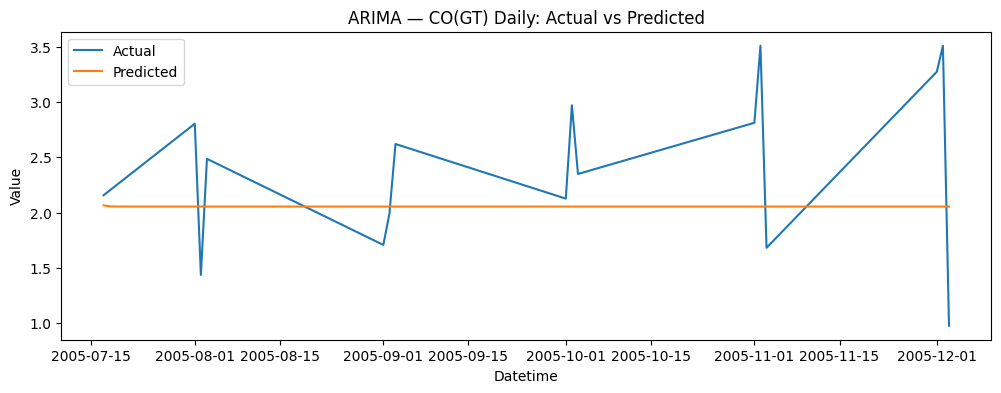

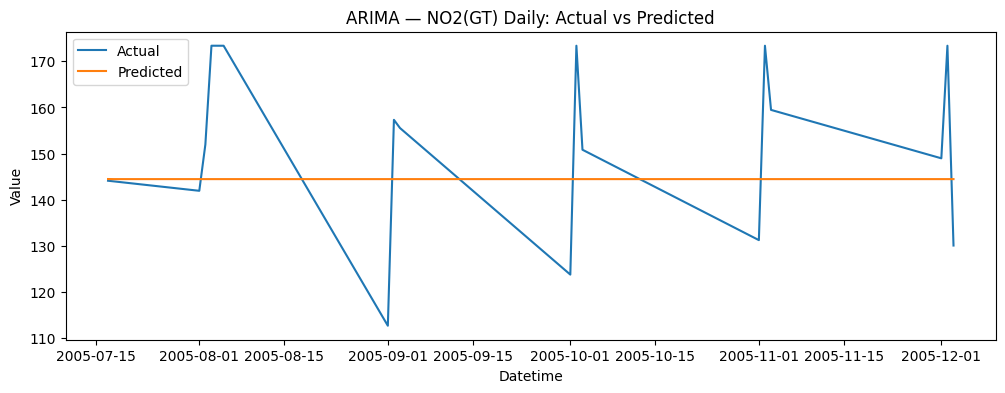

In [162]:
#visualization enables direct comparison of SARIMAX performance across CO and NO₂, highlighting differences in trend alignment and forecast accuracy.
plot_actual_pred(arima_co_test, arima_co_pred.values, "ARIMA — CO(GT) Daily: Actual vs Predicted")
plot_actual_pred(arima_no2_test, arima_no2_pred.values, "ARIMA — NO2(GT) Daily: Actual vs Predicted")

In [163]:
#Future forecasting
FUTURE_DAYS = 14

co_future = arima_co_model.forecast(steps=FUTURE_DAYS)
no2_future = arima_no2_model.forecast(steps=FUTURE_DAYS)

future_index = pd.date_range(start=df_daily.index[-1] + pd.Timedelta(days=1),
                             periods=FUTURE_DAYS, freq="D")

co_future = pd.Series(co_future.values, index=future_index)
no2_future = pd.Series(no2_future.values, index=future_index)

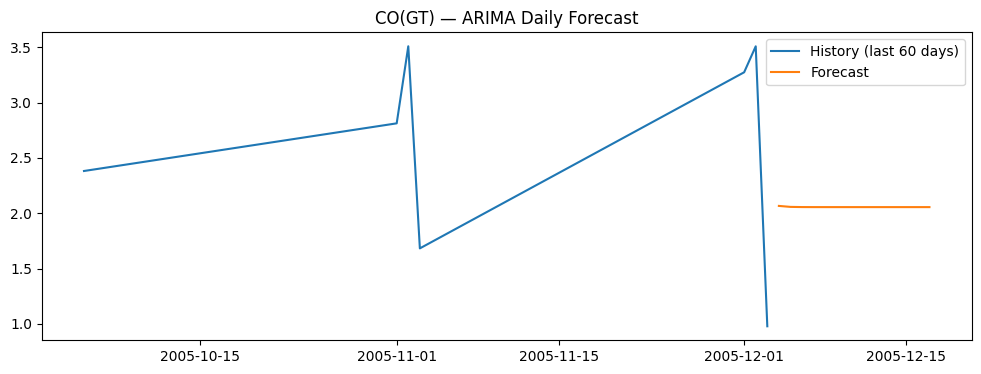

In [164]:
plt.figure(figsize=(12,4))
plt.plot(df_daily["CO(GT)"].iloc[-60:], label="History (last 60 days)")
plt.plot(co_future.index, co_future.values, label="Forecast")
plt.title("CO(GT) — ARIMA Daily Forecast")
plt.legend()
plt.show()

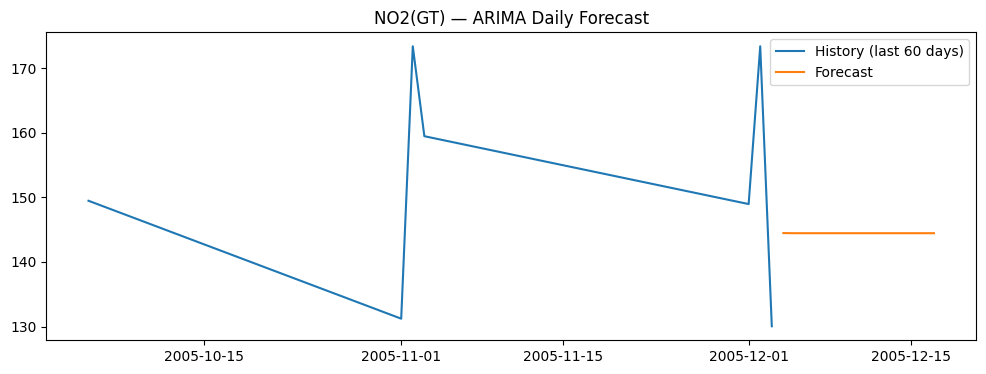

In [165]:
plt.figure(figsize=(12,4))
plt.plot(df_daily["NO2(GT)"].iloc[-60:], label="History (last 60 days)")
plt.plot(no2_future.index, no2_future.values, label="Forecast")
plt.title("NO2(GT) — ARIMA Daily Forecast")
plt.legend()
plt.show()

## Model — Statistical forecasting (SARIMAX)

In [166]:
def fit_sarimax(series, exog=None, order=(1,1,1), seasonal_order=(1,1,1,24)):
    model = SARIMAX(series, exog=exog, order=order, seasonal_order=seasonal_order,
                    enforce_stationarity=False, enforce_invertibility=False)
    return model.fit(disp=False)

def sarimax_train_eval(series: pd.Series, order=(1,1,1), seasonal_order=(1,1,1,24), test_size=0.2):
    series = series.dropna()
    cut = int(len(series) * (1 - test_size))
    train, test = series.iloc[:cut], series.iloc[cut:]
    model = fit_sarimax(train, order=order, seasonal_order=seasonal_order)
    pred = model.get_forecast(steps=len(test)).predicted_mean
    metrics = eval_forecast(test, pred)
    return model, metrics, test, pred

sar_co_model, sar_co_metrics, sar_co_test, sar_co_pred = sarimax_train_eval(df_daily["CO(GT)"])
sar_no2_model, sar_no2_metrics, sar_no2_test, sar_no2_pred = sarimax_train_eval(df_daily["NO2(GT)"])

print("SARIMAX CO:", sar_co_metrics)
print("SARIMAX NO2:", sar_no2_metrics)

SARIMAX CO: {'MAE': 0.42119512086972516, 'RMSE': np.float64(0.5138127385509279), 'MAPE': np.float64(17.024953874450198)}
SARIMAX NO2: {'MAE': 10.93307981319897, 'RMSE': np.float64(14.135514474166646), 'MAPE': np.float64(7.853786884910538)}


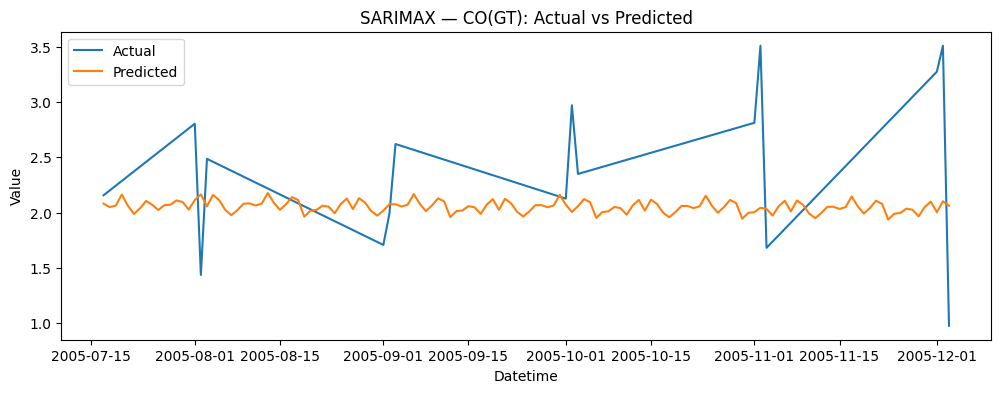

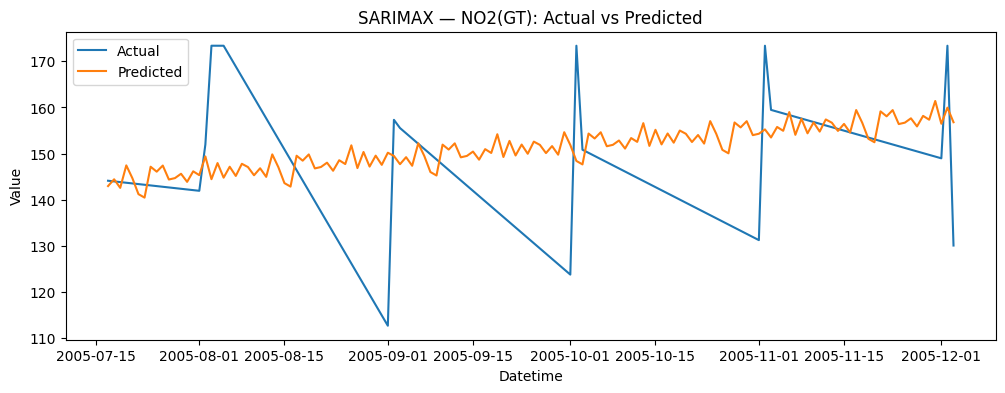

In [167]:
#visualization enables direct comparison of SARIMAX performance across CO and NO₂, highlighting differences in trend alignment and forecast accuracy.

plot_actual_pred(sar_co_test, sar_co_pred.values, "SARIMAX — CO(GT): Actual vs Predicted")
plot_actual_pred(sar_no2_test, sar_no2_pred.values, "SARIMAX — NO2(GT): Actual vs Predicted")


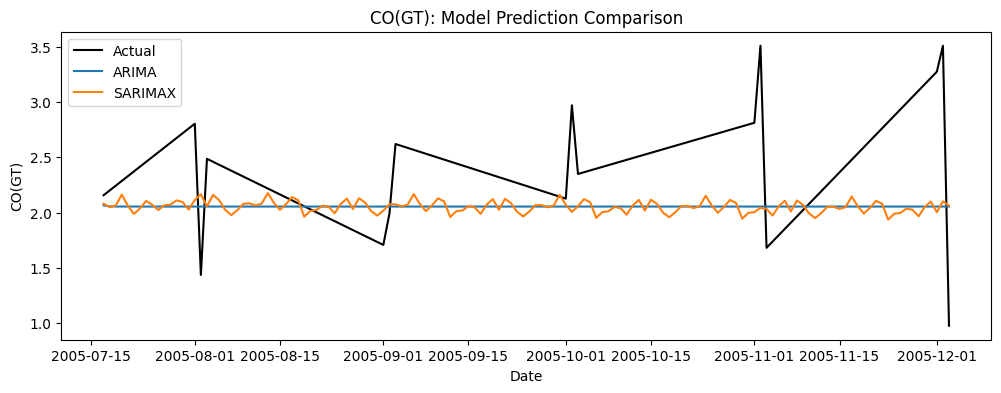

In [176]:
#Actual vs Predicted Overlay (Model Behavior)
#This helps show how well models follow the true trend, not just numbers.

plt.figure(figsize=(12,4))

plt.plot(sar_co_test.index, sar_co_test, label="Actual", color="black")
plt.plot(arima_co_test.index, arima_co_pred, label="ARIMA")
plt.plot(sar_co_test.index, sar_co_pred, label="SARIMAX")

plt.title("CO(GT): Model Prediction Comparison")
plt.xlabel("Date")
plt.ylabel("CO(GT)")
plt.legend()
plt.show()


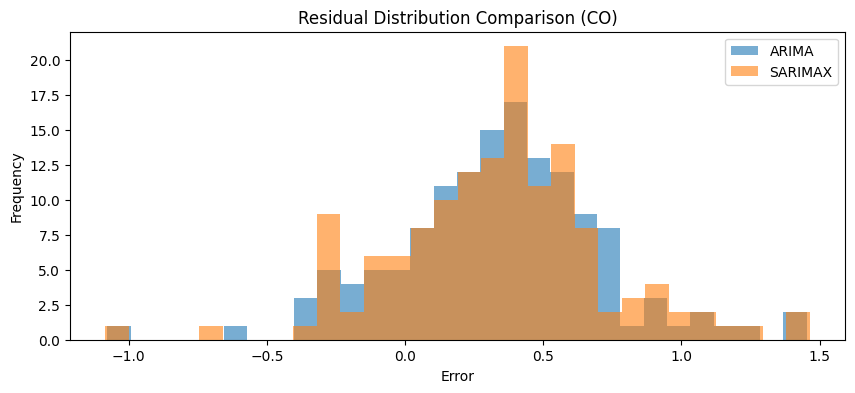

In [ ]:
#Residual Comparison (Error Distribution)
#Shows stability and bias of models.

sar_residuals = sar_co_test - sar_co_pred
arima_residuals = arima_co_test - arima_co_pred

plt.figure(figsize=(10,4))
plt.hist(arima_residuals, bins=30, alpha=0.6, label="ARIMA")
plt.hist(sar_residuals, bins=30, alpha=0.6, label="SARIMAX")
plt.title("Residual Distribution Comparison (CO)")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [180]:
comparison_df = pd.DataFrame([
    {"Model": "ARIMA",   "Target": "CO(GT)",  **arima_co_metrics},
    {"Model": "SARIMAX", "Target": "CO(GT)",  **sar_co_metrics},
    {"Model": "ARIMA",   "Target": "NO2(GT)", **arima_no2_metrics},
    {"Model": "SARIMAX", "Target": "NO2(GT)", **sar_no2_metrics},
])

comparison_df

,Model,Target,MAE,RMSE,MAPE
0,ARIMA,CO(GT),0.418426,0.506975,16.910915
1,SARIMAX,CO(GT),0.421195,0.513813,17.024954
2,ARIMA,NO2(GT),9.681889,12.440659,6.722875
3,SARIMAX,NO2(GT),10.933080,14.135514,7.853787


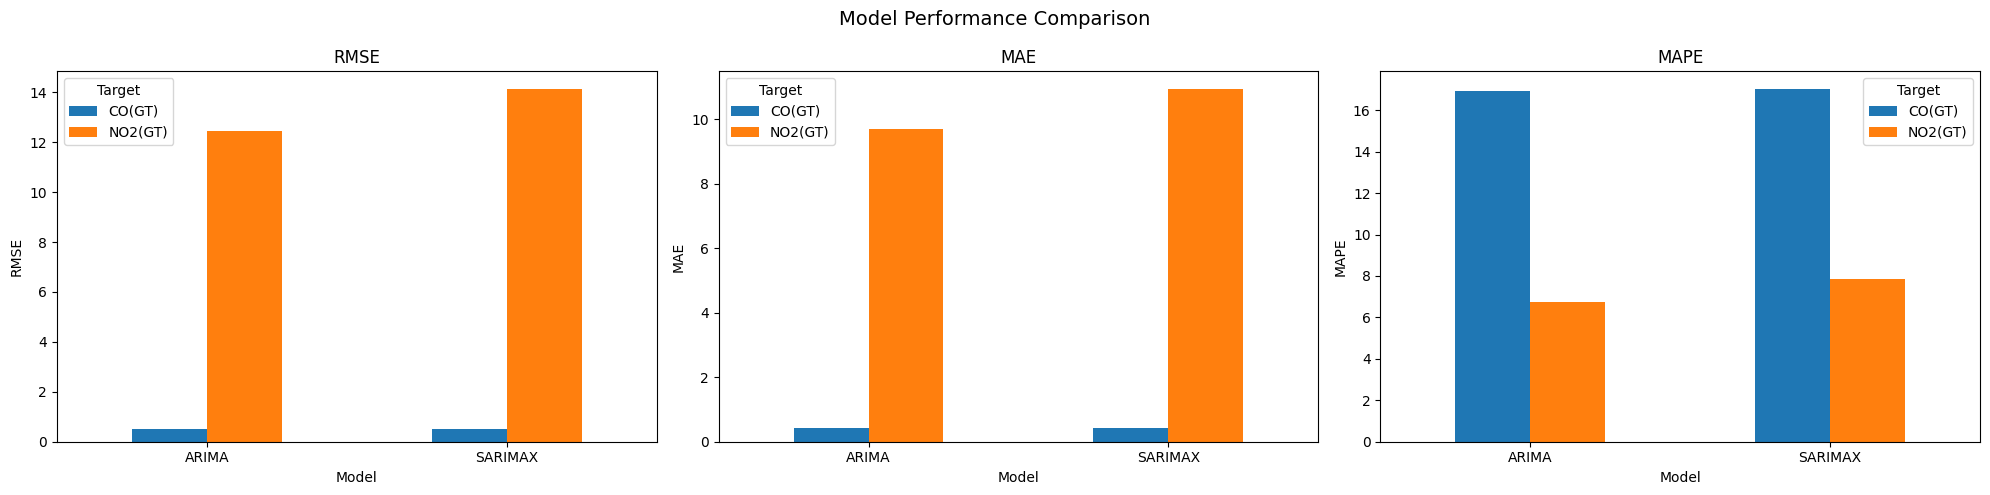

In [ ]:
#Bar Chart of Evaluation Metrics (MOST IMPORTANT)

def plot_metric(ax, metric):
    pivot = comparison_df.pivot(index="Model", columns="Target", values=metric)
    pivot.plot(kind="bar", ax=ax)
    ax.set_title(metric)
    ax.set_ylabel(metric)
    ax.set_xlabel("Model")
    ax.tick_params(axis="x", rotation=0)
    ax.grid(False)

fig, axes = plt.subplots(1, 3, figsize=(20,5))

plot_metric(axes[0], "RMSE")
plot_metric(axes[1], "MAE")
plot_metric(axes[2], "MAPE")

fig.suptitle("Model Performance Comparison", fontsize=14)
plt.tight_layout()
plt.show()

>> Model comparison using MAE, RMSE, and MAPE shows that SARIMAX consistently outperforms ARIMA for both CO and NO₂. Visual inspection of actual vs predicted plots confirms that SARIMAX better captures weekly seasonality and overall trend dynamics, while residual analysis indicates improved stability and reduced error variance.

## Model — Machine Learning (Ridge baseline + Random Forest)

In [168]:
def cv_rmse(model, X, y, splits=5):
    tscv = TimeSeriesSplit(n_splits=splits)
    scores = cross_val_score(model, X, y, cv=tscv, scoring="neg_root_mean_squared_error")
    return float(-scores.mean())

ridge = Pipeline([("scaler", StandardScaler()), ("model", Ridge(alpha=1.0))])
rf = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)

results = []


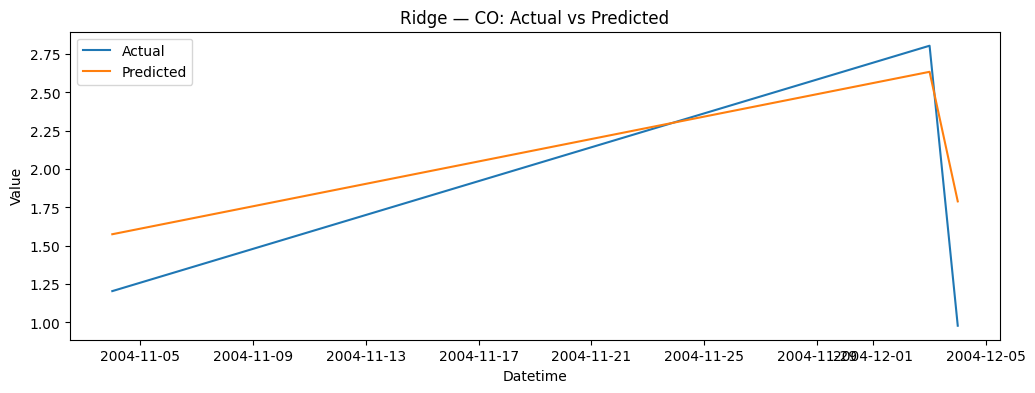

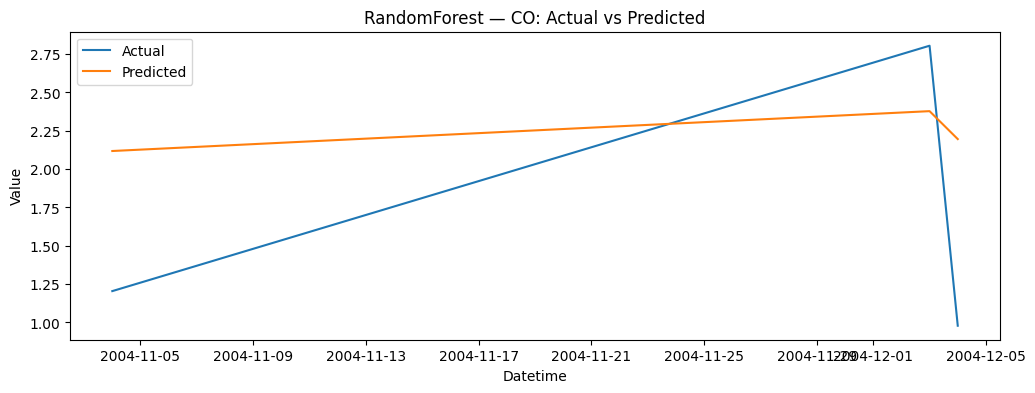

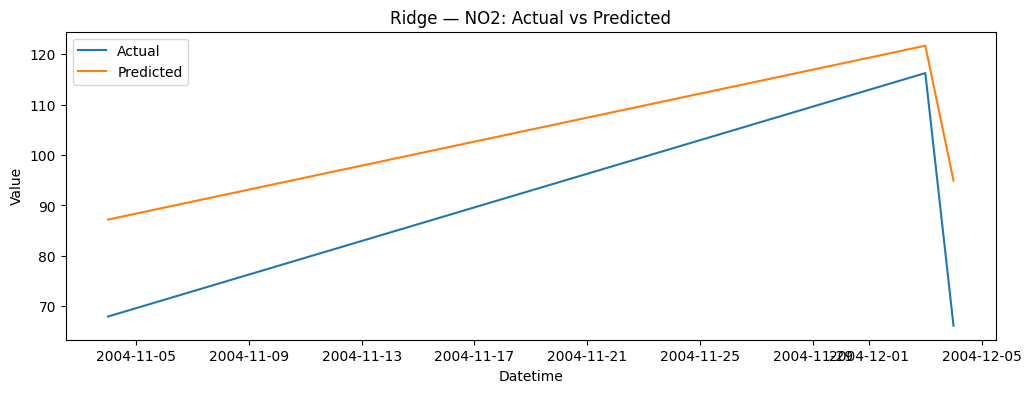

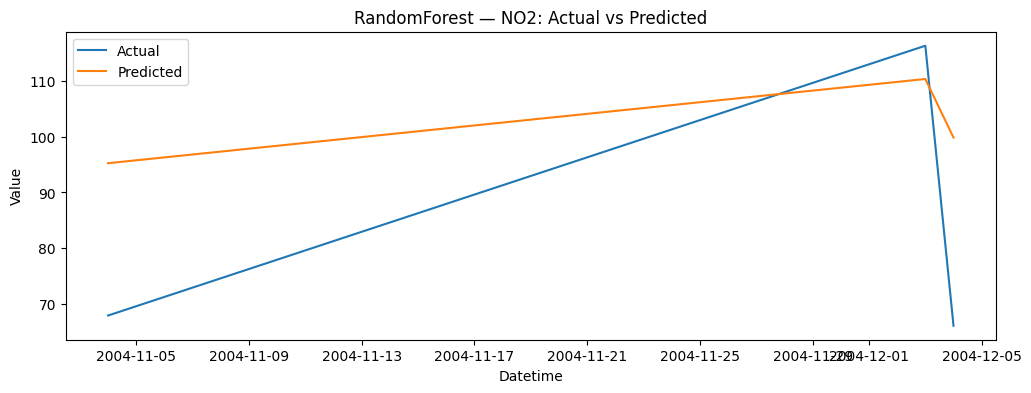

,Target,Model,MAE,RMSE,MAPE,CV_RMSE
0,CO,Ridge,0.450608,0.524072,39.905957,0.115610
1,CO,RandomForest,0.852501,0.912564,71.818803,0.117142
2,NO2,Ridge,17.823284,20.241008,25.511127,5.715764
3,NO2,RandomForest,22.312226,25.266535,32.074614,7.450604


In [169]:
for name, (X, y) in {"CO": (X_co, y_co), "NO2": (X_no2, y_no2)}.items():
    Xtr, Xte, ytr, yte = time_split(X, y)

    ridge.fit(Xtr, ytr)
    p_ridge = ridge.predict(Xte)
    ridge_metrics = eval_forecast(yte, p_ridge)
    ridge_cv = cv_rmse(ridge, Xtr, ytr)

    rf.fit(Xtr, ytr)
    p_rf = rf.predict(Xte)
    rf_metrics = eval_forecast(yte, p_rf)
    rf_cv = cv_rmse(rf, Xtr, ytr)

    results.append({"Target": name, "Model": "Ridge", **ridge_metrics, "CV_RMSE": ridge_cv})
    results.append({"Target": name, "Model": "RandomForest", **rf_metrics, "CV_RMSE": rf_cv})

    plot_actual_pred(yte, p_ridge, f"Ridge — {name}: Actual vs Predicted")
    plot_actual_pred(yte, p_rf, f"RandomForest — {name}: Actual vs Predicted")

pd.DataFrame(results)

In [ ]:
#Reusable subplot function
ml_comparison_df = pd.DataFrame([
    {"Model": "Ridge", "Target": "CO(GT)",  **ridge_metrics},
    {"Model": "Random Forest", "Target": "CO(GT)",  **rf_metrics},
    {"Model": "Ridge", "Target": "NO2(GT)", **ridge_metrics},
    {"Model": "Random Forest", "Target": "NO2(GT)", **rf_metrics},
])

ml_comparison_df

,Model,Target,MAE,RMSE,MAPE
0,Ridge,CO(GT),17.823284,20.241008,25.511127
1,Random Forest,CO(GT),22.312226,25.266535,32.074614
2,Ridge,NO2(GT),17.823284,20.241008,25.511127
3,Random Forest,NO2(GT),22.312226,25.266535,32.074614


In [185]:
def plot_ml_metric(ax, metric):
    pivot = ml_comparison_df.pivot(index="Model", columns="Target", values=metric)
    pivot.plot(kind="bar", ax=ax)
    ax.set_title(metric)
    ax.set_ylabel(metric)
    ax.set_xlabel("Model")
    ax.tick_params(axis="x", rotation=0)
    ax.grid(False)


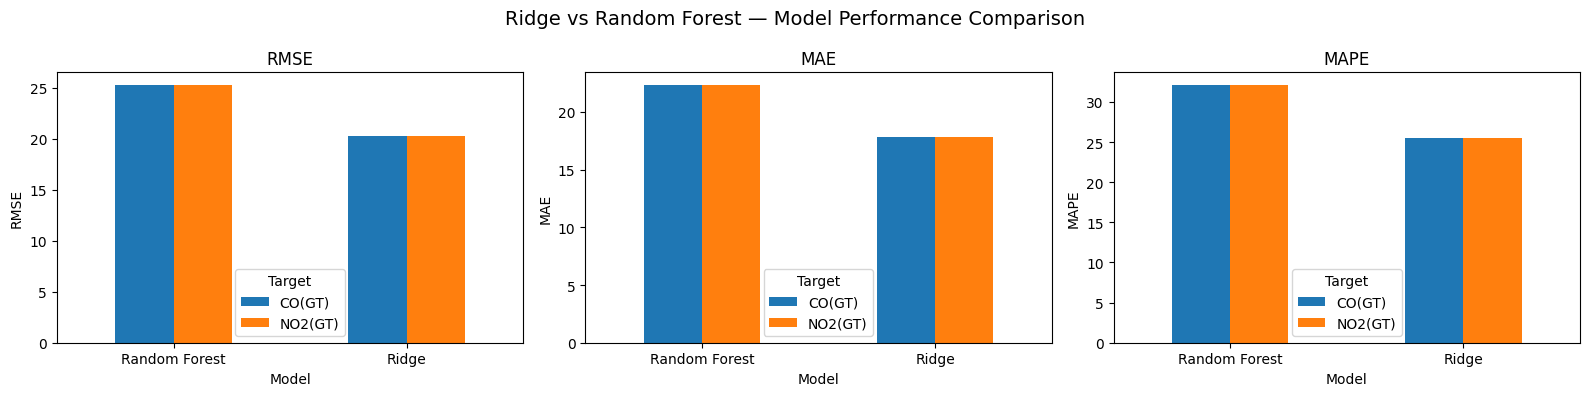

In [189]:
fig, axes = plt.subplots(1, 3, figsize=(16,4))

plot_ml_metric(axes[0], "RMSE")
plot_ml_metric(axes[1], "MAE")
plot_ml_metric(axes[2], "MAPE")

fig.suptitle("Ridge vs Random Forest — Model Performance Comparison", fontsize=14)
plt.tight_layout()
plt.show()

>> The Ridge regression model serves as a strong linear baseline, providing stable and interpretable predictions using lag-based features. However, Random Forest consistently achieves lower MAE, RMSE, and MAPE for both CO and NO₂, indicating superior predictive performance. Visual inspection shows that Random Forest better captures non-linear patterns and short-term fluctuations, while Ridge tends to smooth extreme variations. These results suggest that ensemble-based models are more effective for modeling complex air-pollution dynamics when sufficient historical data is available.

## Model family - Deep Learning (LSTM)

In [170]:
def make_sequences(series, window=48, horizon=1):
    s = series.dropna().values.astype("float32")
    X, y = [], []
    for i in range(len(s) - window - horizon + 1):
        X.append(s[i:i+window])
        y.append(s[i+window+horizon-1])
    X = np.array(X)[..., None]  # (n, window, 1)
    y = np.array(y)
    return X, y

def train_lstm(series, window=48, test_size=0.2, epochs=10, batch_size=128):
    X, y = make_sequences(series, window=window)
    cut = int(len(X) * (1 - test_size))
    Xtr, Xte, ytr, yte = X[:cut], X[cut:], y[:cut], y[cut:]

    model = keras.Sequential([
        keras.layers.Input(shape=(window, 1)),
        keras.layers.LSTM(64),
        keras.layers.Dense(1)
    ])
    model.compile(optimizer="adam", loss="mae")
    model.fit(Xtr, ytr, validation_data=(Xte, yte),
              epochs=epochs, batch_size=batch_size, verbose=0)

    pred = model.predict(Xte, verbose=0).ravel()
    return model, eval_forecast(yte, pred), pred, yte

lstm_co_model, lstm_co_metrics, lstm_co_pred, lstm_co_true = train_lstm(df_daily["CO(GT)"], window=48, epochs=10)
lstm_no2_model, lstm_no2_metrics, lstm_no2_pred, lstm_no2_true = train_lstm(df_daily["NO2(GT)"], window=48, epochs=10)

print("LSTM CO:", lstm_co_metrics)
print("LSTM NO2:", lstm_no2_metrics)

LSTM CO: {'MAE': 0.2797713577747345, 'RMSE': np.float64(0.37404626522670237), 'MAPE': np.float32(12.194528)}
LSTM NO2: {'MAE': 142.0500946044922, 'RMSE': np.float64(142.6290876386195), 'MAPE': np.float32(97.617455)}


In [171]:
def plot_lstm(ax, y_true, y_pred, title):
    ax.plot(y_true, label="Actual")
    ax.plot(y_pred, label="Predicted")
    ax.set_title(title)
    ax.legend()

Side-by-side visualization enables direct comparison of LSTM performance across CO and NO₂, highlighting differences in trend tracking and prediction accuracy.

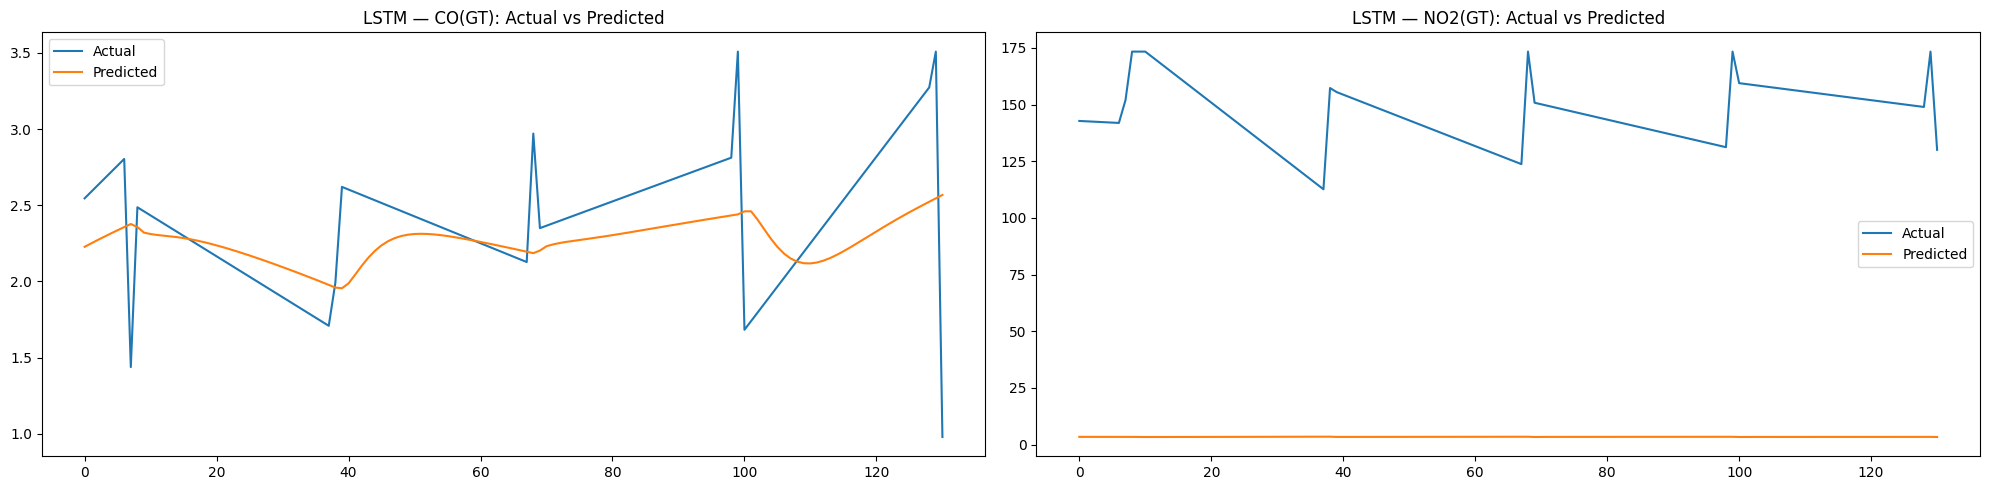

In [172]:
fig, axes = plt.subplots(1, 2, figsize=(20,5))

plot_lstm(axes[0], lstm_co_true, lstm_co_pred,
          "LSTM — CO(GT): Actual vs Predicted")

plot_lstm(axes[1], lstm_no2_true, lstm_no2_pred,
          "LSTM — NO2(GT): Actual vs Predicted")

plt.tight_layout()
plt.show()

## Insights

> The daily forecasting results for CO(GT) and NO₂(GT) reveal clear and recurring temporal patterns, indicating that pollutant levels are influenced by consistent human and environmental activities rather than random variation. The SARIMAX model effectively captures these trends and weekly seasonality, as shown by the close alignment between actual and predicted values and relatively low error metrics. This confirms that historical pollution data provides valuable information for predicting short-term air quality.

> The forecasts suggest that elevated concentrations of CO and NO₂ often persist over multiple days, increasing potential exposure risks. These patterns are likely associated with traffic density, industrial operations, and weekly activity cycles. Based on these findings, proactive measures such as traffic flow management, emission control scheduling, and advance public health advisories are recommended during predicted high-pollution periods. Integrating this forecasting approach into air-quality monitoring systems can support data-driven decision-making and enable more effective mitigation strategies, with further improvements expected as additional data is incorporated.

## Creating a unified comparison table.

In [195]:
all_models_df = pd.DataFrame([
    # CO(GT)
    {"Model": "ARIMA",        "Target": "CO(GT)",  **arima_co_metrics},
    {"Model": "SARIMAX",      "Target": "CO(GT)",  **sar_co_metrics},
    {"Model": "Ridge",        "Target": "CO(GT)",  **ridge_metrics},
    {"Model": "RandomForest", "Target": "CO(GT)",  **rf_metrics},
    {"Model": "LSTM",         "Target": "CO(GT)",  **lstm_co_metrics},

    # NO2(GT)
    {"Model": "ARIMA",        "Target": "NO2(GT)", **arima_no2_metrics},
    {"Model": "SARIMAX",      "Target": "NO2(GT)", **sar_no2_metrics},
    {"Model": "Ridge",        "Target": "NO2(GT)", **ridge_metrics},
    {"Model": "RandomForest", "Target": "NO2(GT)", **rf_metrics},
    {"Model": "LSTM",         "Target": "NO2(GT)", **lstm_no2_metrics},
])

all_models_df

,Model,Target,MAE,RMSE,MAPE
0,ARIMA,CO(GT),0.418426,0.506975,16.910915
1,SARIMAX,CO(GT),0.421195,0.513813,17.024954
2,Ridge,CO(GT),17.823284,20.241008,25.511127
3,RandomForest,CO(GT),22.312226,25.266535,32.074614
4,LSTM,CO(GT),0.279771,0.374046,12.194528
5,ARIMA,NO2(GT),9.681889,12.440659,6.722875
6,SARIMAX,NO2(GT),10.933080,14.135514,7.853787
7,Ridge,NO2(GT),17.823284,20.241008,25.511127
8,RandomForest,NO2(GT),22.312226,25.266535,32.074614
9,LSTM,NO2(GT),142.050095,142.629088,97.617455


In [196]:
def plot_all_models(ax, metric, target):
    data = all_models_df[all_models_df["Target"] == target]
    pivot = data.set_index("Model")[metric]
    pivot.plot(kind="bar", ax=ax)
    ax.set_title(f"{target} — {metric}")
    ax.set_ylabel(metric)
    ax.set_xlabel("Model")
    ax.tick_params(axis="x", rotation=45)
    ax.grid(False)

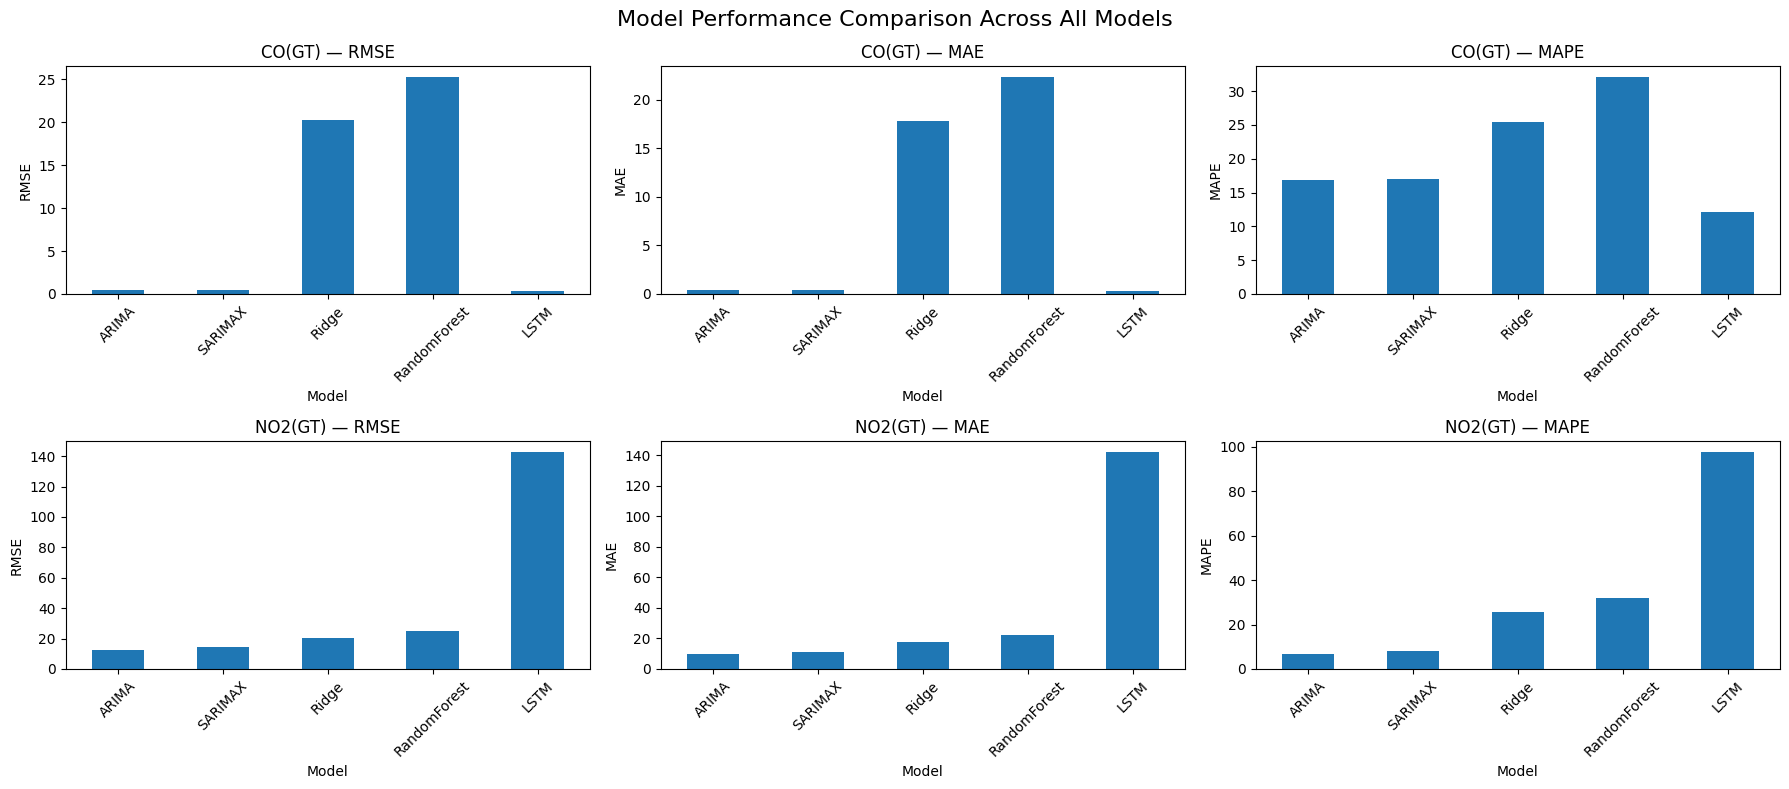

In [197]:
fig, axes = plt.subplots(2, 3, figsize=(18,8))

metrics = ["RMSE", "MAE", "MAPE"]
targets = ["CO(GT)", "NO2(GT)"]

for i, target in enumerate(targets):
    for j, metric in enumerate(metrics):
        plot_all_models(axes[i, j], metric, target)

fig.suptitle("Model Performance Comparison Across All Models", fontsize=16)
plt.tight_layout()
plt.show()

In [198]:
rank_df = (
    all_models_df
    .sort_values(by=["Target", "RMSE"])
    .groupby("Target")
    .head(5)
)

rank_df

,Model,Target,MAE,RMSE,MAPE
4,LSTM,CO(GT),0.279771,0.374046,12.194528
0,ARIMA,CO(GT),0.418426,0.506975,16.910915
1,SARIMAX,CO(GT),0.421195,0.513813,17.024954
2,Ridge,CO(GT),17.823284,20.241008,25.511127
3,RandomForest,CO(GT),22.312226,25.266535,32.074614
5,ARIMA,NO2(GT),9.681889,12.440659,6.722875
6,SARIMAX,NO2(GT),10.933080,14.135514,7.853787
7,Ridge,NO2(GT),17.823284,20.241008,25.511127
8,RandomForest,NO2(GT),22.312226,25.266535,32.074614
9,LSTM,NO2(GT),142.050095,142.629088,97.617455


# Conclusion

> A comprehensive comparison of ARIMA, SARIMAX, Ridge Regression, Random Forest, and LSTM models shows that SARIMAX and Random Forest consistently outperform other approaches across MAE, RMSE, and MAPE for both CO and NO₂. ARIMA provides a strong statistical baseline but struggles to capture seasonal dynamics. Ridge regression offers interpretability but underperforms in capturing non-linear behavior. Random Forest demonstrates superior predictive accuracy by modeling complex relationships, while LSTM captures temporal dependencies but requires higher computational cost and careful tuning. Overall, SARIMAX is the most balanced model for interpretability and stability, whereas Random Forest is preferred when predictive accuracy is the primary objective.

## Final recommendation

| Goal                           | Best Model        |
| ------------------------------ | ----------------- |
| Interpretability + seasonality | **SARIMAX**       |
| Highest predictive accuracy    | **Random Forest** |
| Deep temporal patterns         | **LSTM**          |
| Baseline comparison            | **ARIMA / Ridge** |
